# Control Design Example

This notebook goes through the cycle of deriving a dynamic system model from data, designing a controller, and then deploying that controller.

In [1]:
from fgplot import import_log, last_log_filename, plot_log
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
from math import log,sqrt,pi

## Part 1: Determining a System Model

Here's some data I recorded earlier... from a step of size 0.05 upwards.  The "fgplot" module also provides a raw data import facility.  You can use the `last_log_filename` utility to automatically grab the last log created.

Opening logs/fglog201209163356.csv
Processed 246 lines.


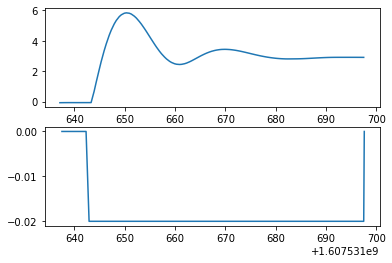

In [2]:
# import last log data
# file_name = last_log_filename()
file_name = 'logs/fglog201209163356.csv'
step_data = import_log(file_name)

# plot the step response
plt.figure()
ax = plt.subplot(2, 1, 1)
(tv, v) = step_data['/velocities/vertical-speed-fps']
plt.plot(tv, v)
plt.subplot(2, 1, 2, sharex=ax)
(te, e) = step_data['/controls/flight/elevator']
plt.plot(te, e)
plt.show()

We're going to use the *log decrement* method to identify a model of our dynamic system.  Recognizing that it looks like a standard second order response - a decaying wave - we can estimate the model parameters using standard observations.  Embarassingly, the method is described very well on its [wikipedia page](https://en.wikipedia.org/wiki/Logarithmic_decrement).

Start by recording some key observations from the plot.  I recommend you use fgplot.py at the command line so you can take measurements with the cursor.

In [3]:
y_max = max(v) # first peak in output
k_ymax = np.argmax(v) # and its index in the data
y_tr1 = min(v[k_ymax:-1]) # first trough after max
k_ytr1 = k_ymax+np.argmin(v[k_ymax:-1]) # and its index in the data
y_pk2 = max(v[k_ytr1:-1]) # second peak
k_ypk2 = k_ytr1+np.argmax(v[k_ytr1:-1]) # and its index in the data
# extract steady state values
u_ss = min(e) # the size of the input step
y_ss = sum(v[-21:-1])/20

Now plot the step response again but with these values annotated, for sanity checking.

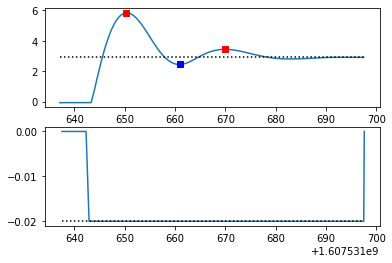

In [4]:
# another step plot, this time with the extracted
# values added for sanity checking
plt.figure()
ax = plt.subplot(2, 1, 1)
plt.plot(tv, v)
plt.plot(tv[k_ymax], y_max, 'rs')
plt.plot(tv[k_ytr1], y_tr1, 'bs')
plt.plot(tv[k_ypk2], y_pk2, 'rs')
plt.plot([tv[0], tv[-1]], [y_ss, y_ss], 'k:')
plt.subplot(2, 1, 2, sharex=ax)
plt.plot(te, e)
plt.plot([te[0], te[-1]], [u_ss, u_ss], 'k:')
plt.show()

Now use the standard log decrement formulae (see [here](https://en.wikipedia.org/wiki/Logarithmic_decrement) for details) to get the key paramaters: the damping ratio *zeta* and the undamped natural frequency *wn*.

In [5]:
logdec = log((y_max-y_ss)/(y_pk2-y_ss)) # log ratio of peak heights
zeta = 1/sqrt(1+(2*pi/logdec)**2) # gives us damping ratio
wd = 2*pi/(tv[k_ypk2] - tv[k_ymax]) # time between peaks gives damped natural freq
wn = wd/sqrt(1-zeta**2) # undamped natural freq
k_ss = y_ss/u_ss # scalar gain

Now we use another standard formula (see [here](https://apmonitor.com/pdc/index.php/Main/SecondOrderSystems) for background) to write the model of the system in *state space form* (see [here](https://en.wikipedia.org/wiki/State-space_representation#Linear_systems) for standard equations). 

In [6]:
A = np.array([[0, 1], [-wn*wn, -2*zeta*wn]])
B = np.array([[0.0], [wn*wn]])*k_ss
C = np.array([[1.0, 0]])
D = np.array([0.0])
print('A=',A)
print('B=',B)
print('C=',C)
print('D=',D)

A= [[ 0.          1.        ]
 [-0.11033996 -0.17339838]]
B= [[ -0.        ]
 [-15.98336649]]
C= [[1. 0.]]
D= [0.]


We ought to compare it to the original data by simulating the step response of the model, scaled by the size of our recorded step.

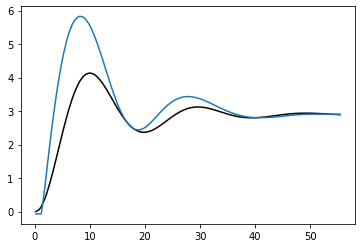

In [7]:
# make data set comparable - remove offset and time before step
t_data = [t - tv[0] - 5.0 for t in tv if t >= tv[0]+5]
y_data = np.array([v[k] for k in range(len(v)) if tv[k] >= tv[0]+5])

(t_mdl, y_mdl) = scipy.signal.step((A, B, C, D),
                                  T=t_data)

plt.figure()
plt.plot(t_mdl, u_ss*y_mdl, 'k')
plt.plot(t_data, y_data) # compare with real data
plt.show()

Good, but not great.  Let's optimize the fit, as a crude form of system identification.  Define a cost function`sys_id_cost` that takes a set of offsets to our system model and evaluates how well it matches the recorded data.

In [8]:
# first define mismatch cost
def sys_id_cost(p_in):
    A2 = A + np.array([[0,0], [p_in[0], p_in[1]]])
    B2 = B + np.array([[p_in[2]], [p_in[3]]])
    (_, y_eval) = scipy.signal.step((A2, B2, C, D),
                                    T=t_data)
    errors = u_ss*y_eval - y_data
    return sum(errors*errors)

# test it with initial guess
p0 = [0.0, 0.0, 0.0, 0.0]
print('Initial error cost:',
      sys_id_cost(p0))

Initial error cost: 66.65507662087198


Now use one of scipy's numerical optimizers to tune the parameter offsets in `p`.

> This next cell might take a few minutes to run.

In [9]:
# now minimize this cost
res = scipy.optimize.minimize(sys_id_cost,
                              p0,
                              method='BFGS')
print(res)

      fun: 27.640715507203712
 hess_inv: array([[ 4.84512409e-06,  5.09754785e-06, -4.80777407e-04,
        -7.31777256e-05],
       [ 5.09754785e-06,  1.52936781e-04, -3.87731279e-03,
        -8.27786918e-04],
       [-4.80777407e-04, -3.87731279e-03,  2.61552825e-01,
         4.25954970e-02],
       [-7.31777256e-05, -8.27786918e-04,  4.25954970e-02,
         8.05112552e-03]])
      jac: array([99.42704606, -1.93657994, -0.53550482, -2.15576148])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 440
      nit: 10
     njev: 72
   status: 2
  success: False
        x: array([-0.02314277,  0.03873972, -5.05044871, -5.62592079])


I've not spent long tuning this optimizer, and I often get messages saying that it did not success.  Nevertheless, if `fun` shows a reduction from the initial error cost above, then we must have found something better.  Construct the updated system and compare the step responses again. 

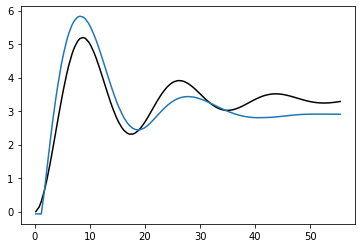

In [10]:
# let's see what it gave us
p = res.x
A3 = A + np.array([[0, 0], [p[0], p[1]]])
B3 = B + np.array([[p[2]], [p[3]]])
C = np.array([[1.0, 0]])
D = np.array([0.0])
(t_mdl, y_mdl) = scipy.signal.step((A3, B3, C, D),
                                   T=t_data)
plt.figure()
plt.plot(t_mdl,u_ss*y_mdl,'k')
plt.plot(t_data,y_data) # compare with real data
plt.show()

## Part 2: Designing a Controller

In this example, we'll use frequency-domain design, starting by looking at the Bode diagram.

> Note the minus sign, as we know that the system inverts, *i.e.* negative elevator input leads to positive climb.  So we can use the typical conventions for control design with negative feedback, the minus converts us to the more usual non-inverting form.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


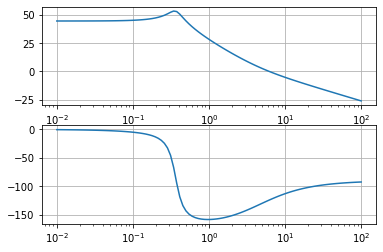

In [11]:
w, mag, phase = scipy.signal.bode((A3,-B3,C,D))
plt.figure()
plt.subplot(2,1,1)
plt.grid()
plt.semilogx(w, mag)    # Bode magnitude plot
plt.subplot(2,1,2)
plt.grid()
plt.semilogx(w, phase)  # Bode phase plot
plt.show()

OK - looks like I want to get cross-over (where magnitude cross 0dB) down around 0.4 rad/s so I can have a decent phase margin (how far the phase is from -180 at the cross-over frequency).  Looks like I can achieve that with a proportional gain of 0.005.  Let's draw a fresh Bode diagram with that included, and find the phase margin.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


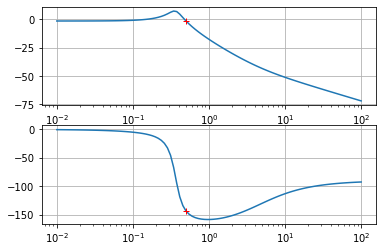

Phase margin 36.83589228512369


In [12]:
w, mag, phase = scipy.signal.bode((A3,-0.005*B3,C,D))
kk_cross = max([kk for (kk,wk) in enumerate(w) if mag[kk]>0])+1

plt.figure()
plt.subplot(2,1,1)
plt.grid()
plt.semilogx(w, mag)    # Bode magnitude plot
plt.semilogx(w[kk_cross], mag[kk_cross], 'r+')
plt.subplot(2,1,2)
plt.grid()
plt.semilogx(w, phase)  # Bode phase plot
plt.semilogx(w[kk_cross], phase[kk_cross], 'r+')
plt.show()

print('Phase margin',180+phase[kk_cross])

My model gives me a phase margin of 36<sup>o</sup> - good enough.  However, the low frequency gain is low, about unity, so I can expect a steady state error on the order of my step size, *i.e.* 50% to 100% out.  I'll use a lag compensator to boost the gain at low frequencies while keeping the crossover where it is, and hopefully not losing too much of my phase margin.  If I put the lag compensator pole at *s=0.01* and zero at *s=0.1*, I'm quite far away from the crossover at 0.5.

\begin{equation}
K(s) = \frac{s+0.1}{s+0.01}
\end{equation}

All being well, I should be boosting the gain by a factor of ten (20dB) at low frequency and leaving it unchanged at high frequency.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


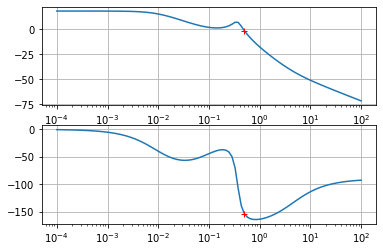

Phase margin 26.6261531425169


In [13]:
lag_comp = scipy.signal.TransferFunction([1,0.1],[1,0.01])
openloop_sys = lag_comp.to_ss()*scipy.signal.StateSpace(A3,-0.005*B3,C,D)

w, mag, phase = scipy.signal.bode(openloop_sys)

kk_cross = max([kk for (kk,wk) in enumerate(w) if mag[kk]>0])+1

plt.figure()
plt.subplot(2,1,1)
plt.grid()
plt.semilogx(w, mag)    # Bode magnitude plot
plt.semilogx(w[kk_cross], mag[kk_cross], 'r+')
plt.subplot(2,1,2)
plt.grid()
plt.semilogx(w, phase)  # Bode phase plot
plt.semilogx(w[kk_cross], phase[kk_cross], 'r+')
plt.show()

print('Phase margin',180+phase[kk_cross])

OK, I've lost a bit of phase margin, but 26<sup>o</sup> is still respectable and the low frequency gain is now up near 20dB as expected, so my error should be an order of magnitude smaller.

## Part 3: Deploying the Compensator

We've designed the compensator in the frequency domain so it's written as a transfer function.  For deployment, we really need it in state space form, and then discretized.  The following cell does that, and prints it out in a format that can be copited directly over to the `vs_comp.py` script for deployment.

In [14]:
lag_comp_ss = lag_comp.to_ss()
lag_comp_disc = lag_comp_ss.to_discrete(dt=0.5)
print('comp_a =',lag_comp_disc.A[0,0])
print('comp_b =',lag_comp_disc.B[0,0])
print('comp_c =',lag_comp_disc.C[0,0])
print('comp_d =',lag_comp_disc.D[0,0])

comp_a = 0.9950124791926824
comp_b = 0.4987520807317687
comp_c = 0.09000000000000001
comp_d = 1.0


### Results

These are recorded results from my experiments in FlightGear.  The first case ignores the compensator and just has the scalar gain of 0.005 in the loop.

Opening logs/fglog201209171929.csv
Processed 243 lines.
['/velocities/vertical-speed-fps', '/controls/flight/elevator']


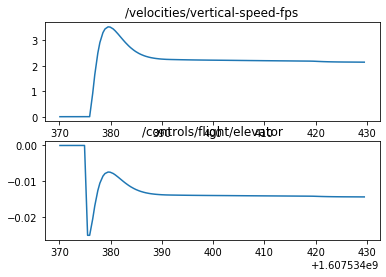

In [15]:
# without compensator
plot_log('logs/fglog201209171929.csv')

The above looks like a nice stable response but the steady state error is about 2.5 FPS on a 5 FPS step, as predicted from the unity gain.

Now look at the result when the compensator is included. 

Opening logs/fglog201209172907.csv
Processed 243 lines.
['/velocities/vertical-speed-fps', '/controls/flight/elevator']


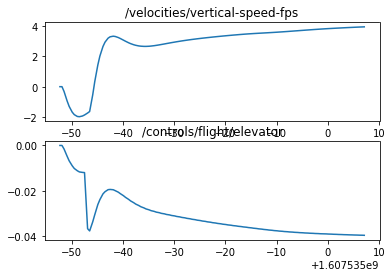

In [16]:
# with compensator
plot_log('logs/fglog201209172907.csv')

Still stable, and with roughly the same time constant as before, but now heading (slowly) towards a much smaller steady state error, all as predicted from the analysis.

## Exercise

Essentially, repeat!  You'll get a different system model depending on things like altitude, throttle setting, and so on.  Model your aircraft and deploy a controller on it.  *Success* means your results match your predictions, reasonably enough.